# Delta-Hedging Backtest (SVI + Black–Scholes)

This notebook demonstrates daily **delta-hedging** of a vanilla call using:
- **Black–Scholes** pricing,
- **IV from an arbitrage-free SVI surface** fitted to the *current* option chain,
- **Frozen surface** (sticky-moneyness) for simplicity/reproducibility.

**Steps**
1) Load underlying prices (via `data_loader.fetch_stock_data`).  
2) Build a single-day **SVI snapshot** (via `data_loader.fetch_current_chain`).  
3) Select a *future* expiry from the current chain and set an **ATM start**.  
4) Run a **daily delta-hedge** backtest on a recent window.  
5) Plot and print diagnostics.


## 0. Imports & helper functions

We reuse:
* `black_scholes_price` from `src/black_scholes.py`.  
* `fit_svi_surface` from `src/svi_surface.py`.  
* Our own delta function and surface IV query helper.  


In [2]:
import math, numpy as np, pandas as pd, os, sys
import matplotlib.pyplot as plt
# Add the repo root (one level up from notebooks) to Python path
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_root)
import pandas as pd
import src.hurst as hurst
from src.hurst import hurst_dfa, hurst_rs
plt.rcParams.update({
    "figure.figsize": (8.0, 4.6),
    "axes.grid": True,
    "grid.alpha": 0.35
})

from src.svi_surface import fit_svi_surface
from src.black_scholes import black_scholes_price,bs_delta_call
from data.data_loader import fetch_stock_data, get_latest_price, fetch_current_chain
def iv_from_surface_safe(surf, S, K, T, r, q, vol_floor=1e-4):
    """
    Robust IV lookup from SVI:
      - Clamp T into [min_tenor, max_tenor] for stable interpolation.
      - Evaluate at log-moneyness k = ln(K/F(T)).
      - Apply a small floor to avoid sigma→0 artifacts.
    """
    Tq = float(np.clip(T, np.min(surf.tenors), np.max(surf.tenors)))
    F  = S * np.exp((r - q) * Tq)
    k  = np.log(K / F)
    iv = float(surf.iv(np.array([k]), Tq))
    return max(iv, vol_floor)


## 1) Underlying price path

We load daily adjusted closes for the chosen ticker.  
We’ll define a **snapshot date** (last bar of the series) to align the SVI calibration.


In [3]:
TICKER = "AAPL"
START  = "2024-01-02"
r, q   = 0.02, 0.00   # flat demo rates

# Load OHLC (your helper already uses auto_adjust=True)
stock_df = fetch_stock_data(TICKER, start=START)
S_series = stock_df["Close"].dropna()
assert not S_series.empty, "No prices loaded."

snapshot_date = pd.to_datetime(stock_df.index[-1])  # align SVI maturity with this date
S_snap = get_latest_price(stock_df)                 # spot at snapshot date
print(f"[INFO] prices: {S_series.index[0].date()} → {snapshot_date.date()} | last={S_snap:.2f}")


[*********************100%***********************]  1 of 1 completed

[INFO] prices: 2024-01-02 → 2025-09-26 | last=255.46


## 2. Build SVI surface snapshot

We fetch current option chains via `yfinance`, invert mid prices to implied vols,  
fit an **arbitrage-free SVI surface**, and use it for IV queries during the backtest.

If no market data is available, we fall back to a **synthetic SVI smile**.  


In [4]:
def invert_iv_call_mid(S, K, T, r, q, mid, tol=1e-8, iters=80):
    """Bisection IV inverter with correct price bounds for Euro call."""
    F = S * math.exp((r - q) * T)
    lower = max(0.0, math.exp(-r * T) * (F - K))
    upper = S * math.exp(-q * T)
    p = float(np.clip(mid, lower, upper))
    lo, hi = 1e-6, 5.0
    for _ in range(iters):
        m = 0.5 * (lo + hi)
        pm = black_scholes_price(S, K, T, r, m, option_type="call")
        if pm > p: hi = m
        else:      lo = m
        if hi - lo < tol: break
    return 0.5 * (lo + hi)

def build_surface_snapshot_from_dataloader(ticker, S_ref, r, q, snapshot_date, max_expiries=8):
    raw = fetch_current_chain(ticker)  # columns: expiration, strike, type, mid
    if raw is None or raw.empty:
        raise RuntimeError("fetch_current_chain returned empty")
    raw = raw.dropna().copy()
    raw["type"] = raw["type"].str.lower()

    calls = raw[(raw["type"] == "call") & (raw["mid"] > 1e-4) & (raw["strike"] > 1e-6)].copy()
    if calls.empty:
        raise RuntimeError("No valid call quotes")

    exps_sorted = np.sort(pd.to_datetime(calls["expiration"].unique()))
    pick_idx = np.round(np.linspace(0, len(exps_sorted)-1, min(max_expiries, len(exps_sorted)))).astype(int)
    picked = [exps_sorted[i] for i in pick_idx]

    t0 = np.datetime64(pd.to_datetime(snapshot_date))
    chains = {}
    for exp in picked:
        sl = calls[calls["expiration"] == exp].copy()
        if sl.empty:
            continue
        T = max(1e-9, (np.datetime64(exp) - t0) / np.timedelta64(1, "D")) / 365.0
        if T <= 0:
            continue

        # moneyness band: tighter for tiny T
        F_T = S_ref * math.exp((r - q) * T)
        k = np.log(sl["strike"].to_numpy(float) / F_T)
        band = 0.35 if T < 0.03 else (0.5 if T < 0.15 else 0.7)
        sl = sl.iloc[np.where(np.abs(k) <= band)[0]]
        if sl.empty:
            continue

        K = sl["strike"].to_numpy(float)
        M = sl["mid"].to_numpy(float)
        ivs = np.array([invert_iv_call_mid(S_ref, float(k_), T, r, q, float(p_)) for k_, p_ in zip(K, M)])

        if ivs.size >= 12:
            lo, hi = np.quantile(ivs, [0.05, 0.95])
            keep = (ivs > 1e-4) & (ivs < 3.0) & (ivs >= lo) & (ivs <= hi)
            K, ivs = K[keep], ivs[keep]

        if K.size >= 10:
            chains[T] = {"K": K, "iv": ivs}

    if not chains:
        raise RuntimeError("No clean expiries after filtering/inversion")

    surf = fit_svi_surface(chains, S0=S_ref, r=r, q=q, mode="iv")
    return surf, chains

surf, chains_used = build_surface_snapshot_from_dataloader(
    TICKER, S_ref=S_snap, r=r, q=q, snapshot_date=snapshot_date
)
print("Surface tenors:", [f"{t:.2f}" for t in sorted(surf.tenors)])


Surface tenors: ['0.02', '0.08', '0.15', '0.40', '0.63', '0.98', '1.30', '2.32']


## 3) Choose a future expiry and set **ATM at t₀**

Pick the **nearest future expiry** (at least 7 days after the snapshot).  
Run the backtest on the **last 90 business days** ending at the snapshot date.  
Strike K is set to the **forward** at $t_0$ (true ATM).


In [5]:
# choose a future expiry from the current chain
exps_all = np.sort(pd.to_datetime(fetch_current_chain(TICKER)["expiration"].unique()))
future_exps = exps_all[exps_all > snapshot_date + pd.Timedelta(days=7)]
assert future_exps.size > 0, "No future expiries found."
expiry = pd.to_datetime(future_exps[0])

# backtest window (last N business days up to snapshot)
N_BACK = 90
S_series_win = S_series[S_series.index <= snapshot_date].iloc[-N_BACK:]
assert not S_series_win.empty
S0 = S_series_win.iloc[0].item()

# ATM at t0: K = forward
T0 = (expiry - S_series_win.index[0]).days / 365.0
F0 = S0 * math.exp((r - q) * T0)
K  = float(F0)   # *true* ATM (no rounding)

# sanity at t0
iv0    = iv_from_surface_safe(surf, S0, K, T0, r, q)
delta0 = bs_delta_call(S0, K, T0, r, q, iv0)
price0 = black_scholes_price(S0, K, T0, r, iv0, option_type="call")
print(f"ATM t0 -> K={K:.2f}  T0={T0:.3f}y  IV0={iv0*100:.2f}%  Δ0={delta0:.2f}  Price0={price0:.2f}")


ATM t0 -> K=208.25  T0=0.392y  IV0=26.85%  Δ0=0.53  Price0=13.84


C:\Users\datog\AppData\Local\Temp\ipykernel_44088\1476137392.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  iv = float(surf.iv(np.array([k]), Tq))


## 4) Delta-hedge backtest (daily re-hedge)

Long 1 option, short Δ shares to stay delta-neutral.  
Cash account accrues at **r**.  
We query IV each day from the **frozen SVI** (sticky-moneyness).


In [6]:
def backtest_delta_hedge(S, dates, K, expiry, r, q, option_type, surf):
    S = np.asarray(S, float).reshape(-1)      # ensure 1-D
    dates = pd.to_datetime(dates)
    n = S.shape[0]
    cash = 0.0
    pos_stock = 0.0
    prices, deltas, vols, times = [], [], [], []

    # t0
    T = max(0.0, (expiry - dates[0]).days/365.0)
    sigma = iv_from_surface_safe(surf, S[0], K, T, r, q)
    price = black_scholes_price(S[0], K, T, r, sigma, option_type="call")
    delta = bs_delta_call(S[0], K, T, r, q, sigma) if option_type=="call" else \
            (bs_delta_call(S[0], K, T, r, q, sigma) - 1)
    pos_stock = -delta
    cash = -price + (-pos_stock)*S[0]
    prices.append(price); deltas.append(delta); vols.append(sigma); times.append(T)

    for t in range(1, n):
        dt = max(1/365, (dates[t] - dates[t-1]).days/365.0)
        cash *= math.exp(r*dt)

        T = max(0.0, (expiry - dates[t]).days/365.0)
        sigma = iv_from_surface_safe(surf, S[t], K, T, r, q)
        price_new = black_scholes_price(S[t], K, T, r, sigma, option_type="call")
        delta_new = bs_delta_call(S[t], K, T, r, q, sigma) if option_type=="call" else \
                    (bs_delta_call(S[t], K, T, r, q, sigma) - 1)

        d_pos = -delta_new - pos_stock
        cash -= d_pos * S[t]
        pos_stock += d_pos

        prices.append(price_new); deltas.append(delta_new); vols.append(sigma); times.append(T)

    payoff = max(S[-1]-K, 0.0) if option_type=="call" else max(K-S[-1], 0.0)
    cash += payoff + pos_stock * S[-1]

    # flatten to 1-D before DataFrame
    track = pd.DataFrame({
        "S":     np.asarray(S,      float).reshape(-1),
        "time":  np.asarray(times,  float).reshape(-1),
        "sigma": np.asarray(vols,   float).reshape(-1),
        "price": np.asarray(prices, float).reshape(-1),
        "delta": np.asarray(deltas, float).reshape(-1),
    }, index=pd.DatetimeIndex(dates))
    return cash, track

pnl, track = backtest_delta_hedge(
    S_series_win.values, S_series_win.index, K, expiry, r, q, "call", surf
)
print(f"Delta-hedge PnL (ATM call): {pnl:.2f}")


Delta-hedge PnL (ATM call): -0.74


C:\Users\datog\AppData\Local\Temp\ipykernel_44088\1476137392.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  iv = float(surf.iv(np.array([k]), Tq))


## 5) Plots & diagnostics

We show spot, option mark, IV path and delta.  
We also print a quick summary and a moneyness path check.


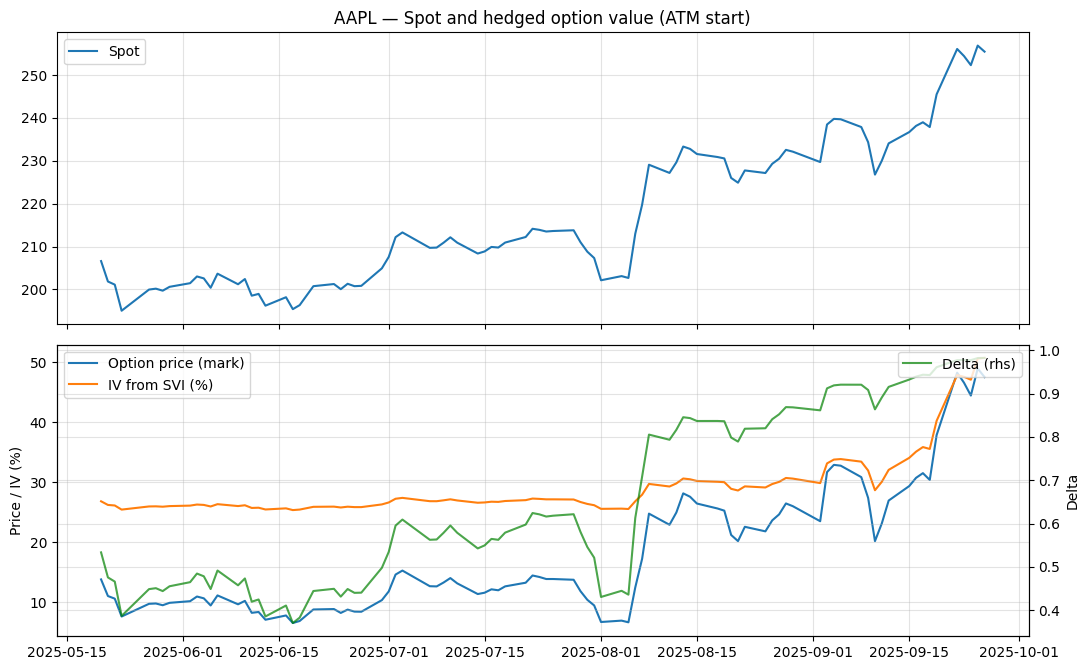

Start price: 13.8358 End price: 47.5322 Avg IV(%): 29.34
Delta range: 0.37 → 0.983
k path (mean, min, max): -0.043889157168318704 -0.21766210821837392 0.06472749717230174


In [7]:
# --- moneyness path diagnostic (robust) ---
idx = pd.DatetimeIndex(S_series_win.index)               # ensure DatetimeIndex
t_years = (pd.to_datetime(expiry) - idx).days.to_numpy() / 365.0  # 1-D float array
F_path  = S_series_win.to_numpy() * np.exp((r - q) * t_years)     # 1-D
k_path  = np.log(K / F_path)                                      # 1-D

# (optional) sanity
# print("shapes:", S_series_win.shape, t_years.shape, F_path.shape, k_path.shape)

fig, ax = plt.subplots(2, 1, figsize=(11, 6.8), sharex=True)
ax[0].plot(idx, S_series_win.to_numpy(), label="Spot")
ax[0].set_title(f"{TICKER} — Spot and hedged option value (ATM start)")
ax[0].legend()

ax1 = ax[1]; ax2 = ax1.twinx()
ax1.plot(track.index, track["price"], label="Option price (mark)")
ax1.plot(track.index, track["sigma"]*100, label="IV from SVI (%)")
ax2.plot(track.index, track["delta"], "g", alpha=0.7, label="Delta (rhs)")
ax1.legend(loc="upper left"); ax2.legend(loc="upper right")
ax1.set_ylabel("Price / IV (%)"); ax2.set_ylabel("Delta")
plt.tight_layout(); plt.show()

print("Start price:", round(track['price'].iloc[0], 4),
      "End price:", round(track['price'].iloc[-1], 4),
      "Avg IV(%):", round(track['sigma'].mean()*100, 2))
print("Delta range:", round(track['delta'].min(), 3), "→", round(track['delta'].max(), 3))
print("k path (mean, min, max):", float(np.mean(k_path)), float(np.min(k_path)), float(np.max(k_path)))


## Notes & next steps

- We used a **frozen** SVI snapshot calibrated on the latest chain; IV is read as
  $\sigma_t = \sigma_{\text{SVI}}(k_t, T_t)$ with **sticky-moneyness** dynamics.
- To get more realism, archive chains daily and refit SVI **per day**, then mark with that day’s surface.
- Try: sticky-**strike** vs sticky-**moneyness**, different hedge frequencies, and simple transaction costs.
- Add theta/gamma series to PnL-attribute (gamma-theta vs smile/vol component).


PnL (Sticky-moneyness): -0.74
PnL (Sticky-strike)  : -3.87


C:\Users\datog\AppData\Local\Temp\ipykernel_44088\3828662762.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  iv = float(surf.iv(np.array([k]), Tq))
C:\Users\datog\AppData\Local\Temp\ipykernel_44088\3828662762.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  iv = float(surf.iv(np.array([k_star]), Tq))


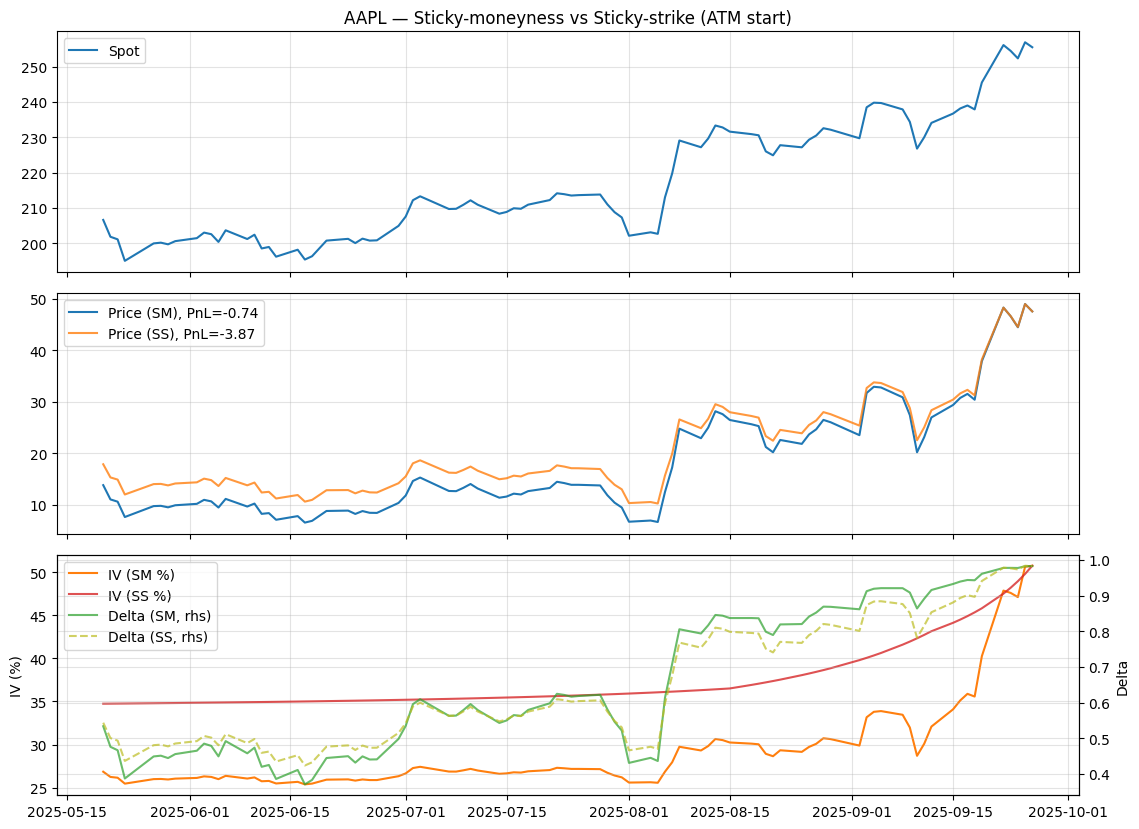

Summary (SM): {'StartPx': 13.835812864819076, 'EndPx': 47.532159022152314, 'AvgIV%': 29.338714323593067, 'Δmin': 0.3703380719328355, 'Δmax': 0.9827343938538702}
Summary (SS): {'StartPx': 17.885521676451262, 'EndPx': 47.532159022152314, 'AvgIV%': 37.53222158340138, 'Δmin': 0.4232946107090693, 'Δmax': 0.9837292372065845}


In [8]:
# =========================
# Sticky-moneyness vs Sticky-strike comparison
# =========================

def iv_sm(surf, S, K, T, r, q, S_snap=None):
    """Sticky-moneyness IV: depends on current S via k_t = ln(K / F_t)."""
    Tq = float(np.clip(T, np.min(surf.tenors), np.max(surf.tenors)))
    F  = S * np.exp((r - q) * Tq)
    k  = np.log(K / F)
    iv = float(surf.iv(np.array([k]), Tq))
    return max(iv, 1e-4)

def iv_ss(surf, S, K, T, r, q, S_snap):
    """Sticky-strike IV: anchored to snapshot forward F_snap(T)."""
    Tq = float(np.clip(T, np.min(surf.tenors), np.max(surf.tenors)))
    F_snap_T = S_snap * np.exp((r - q) * Tq)
    k_star   = np.log(K / F_snap_T)
    iv = float(surf.iv(np.array([k_star]), Tq))
    return max(iv, 1e-4)

def backtest_with_ivfn(S, dates, K, expiry, r, q, surf, iv_fn, label, S_snap=None):
    S = np.asarray(S, float).reshape(-1)
    dates = pd.to_datetime(dates)
    n = S.shape[0]

    cash = 0.0
    pos_stock = 0.0
    prices, deltas, vols, times = [], [], [], []

    # t0
    T = max(0.0, (expiry - dates[0]).days/365.0)
    sigma = iv_fn(surf, S[0], K, T, r, q, S_snap)
    price = black_scholes_price(S[0], K, T, r, sigma, option_type="call")
    delta = bs_delta_call(S[0], K, T, r, q, sigma)

    pos_stock = -delta
    cash = -price + (-pos_stock)*S[0]
    prices.append(price); deltas.append(delta); vols.append(sigma); times.append(T)

    for t in range(1, n):
        dt = max(1/365, (dates[t] - dates[t-1]).days/365.0)
        cash *= math.exp(r*dt)

        T = max(0.0, (expiry - dates[t]).days/365.0)
        sigma = iv_fn(surf, S[t], K, T, r, q, S_snap)
        price_new = black_scholes_price(S[t], K, T, r, sigma, option_type="call")
        delta_new = bs_delta_call(S[t], K, T, r, q, sigma)

        d_pos = -delta_new - pos_stock
        cash -= d_pos * S[t]
        pos_stock += d_pos

        prices.append(price_new); deltas.append(delta_new); vols.append(sigma); times.append(T)

    payoff = max(S[-1]-K, 0.0)
    cash += payoff + pos_stock * S[-1]

    track = pd.DataFrame({
        "S":     S,
        "time":  np.asarray(times,  float).reshape(-1),
        "sigma": np.asarray(vols,   float).reshape(-1),
        "price": np.asarray(prices, float).reshape(-1),
        "delta": np.asarray(deltas, float).reshape(-1),
        "model": label
    }, index=pd.DatetimeIndex(dates))
    return cash, track

# Run both
pnl_sm, tr_sm = backtest_with_ivfn(S_series_win.values, S_series_win.index, K, expiry, r, q, surf, iv_sm, "SM", S_snap=None)
pnl_ss, tr_ss = backtest_with_ivfn(S_series_win.values, S_series_win.index, K, expiry, r, q, surf, iv_ss, "SS", S_snap=S_snap)

print(f"PnL (Sticky-moneyness): {pnl_sm:.2f}")
print(f"PnL (Sticky-strike)  : {pnl_ss:.2f}")

# Plot side-by-side comparisons
fig, ax = plt.subplots(3, 1, figsize=(11.5, 8.4), sharex=True)

# Spot
ax[0].plot(S_series_win.index, S_series_win.values, label="Spot", color="tab:blue")
ax[0].set_title(f"{TICKER} — Sticky-moneyness vs Sticky-strike (ATM start)")
ax[0].legend(loc="upper left")

# Option marks
ax[1].plot(tr_sm.index, tr_sm["price"], label=f"Price (SM), PnL={pnl_sm:.2f}")
ax[1].plot(tr_ss.index, tr_ss["price"], label=f"Price (SS), PnL={pnl_ss:.2f}", alpha=0.8)
ax[1].legend(loc="upper left")

# IV and Delta (twin y-axis)
ax2 = ax[2].twinx()
ax[2].plot(tr_sm.index, tr_sm["sigma"]*100, label="IV (SM %)", color="tab:orange")
ax[2].plot(tr_ss.index, tr_ss["sigma"]*100, label="IV (SS %)", color="tab:red", alpha=0.8)
ax2.plot(tr_sm.index, tr_sm["delta"], color="tab:green", alpha=0.7, label="Delta (SM, rhs)")
ax2.plot(tr_ss.index, tr_ss["delta"], color="tab:olive", alpha=0.7, linestyle="--", label="Delta (SS, rhs)")

# legends
h1, l1 = ax[2].get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax[2].legend(h1+h2, l1+l2, loc="upper left")

ax[2].set_ylabel("IV (%)")
ax2.set_ylabel("Delta")
plt.tight_layout(); plt.show()

# Small summary
def summarize(track):
    return {
        "StartPx": float(track["price"].iloc[0]),
        "EndPx": float(track["price"].iloc[-1]),
        "AvgIV%": float(track["sigma"].mean()*100),
        "Δmin": float(track["delta"].min()),
        "Δmax": float(track["delta"].max())
    }

print("Summary (SM):", summarize(tr_sm))
print("Summary (SS):", summarize(tr_ss))


[*********************100%***********************]  1 of 1 completed
C:\Users\datog\AppData\Local\Temp\ipykernel_44088\1745727049.py:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  iv = float(surf.iv(np.array([k]), Tq))
C:\Users\datog\AppData\Local\Temp\ipykernel_44088\1745727049.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  iv = float(surf.iv(np.array([k_star]), Tq))


PnL (Sticky-moneyness): -0.74
PnL (Sticky-strike)  : -3.87


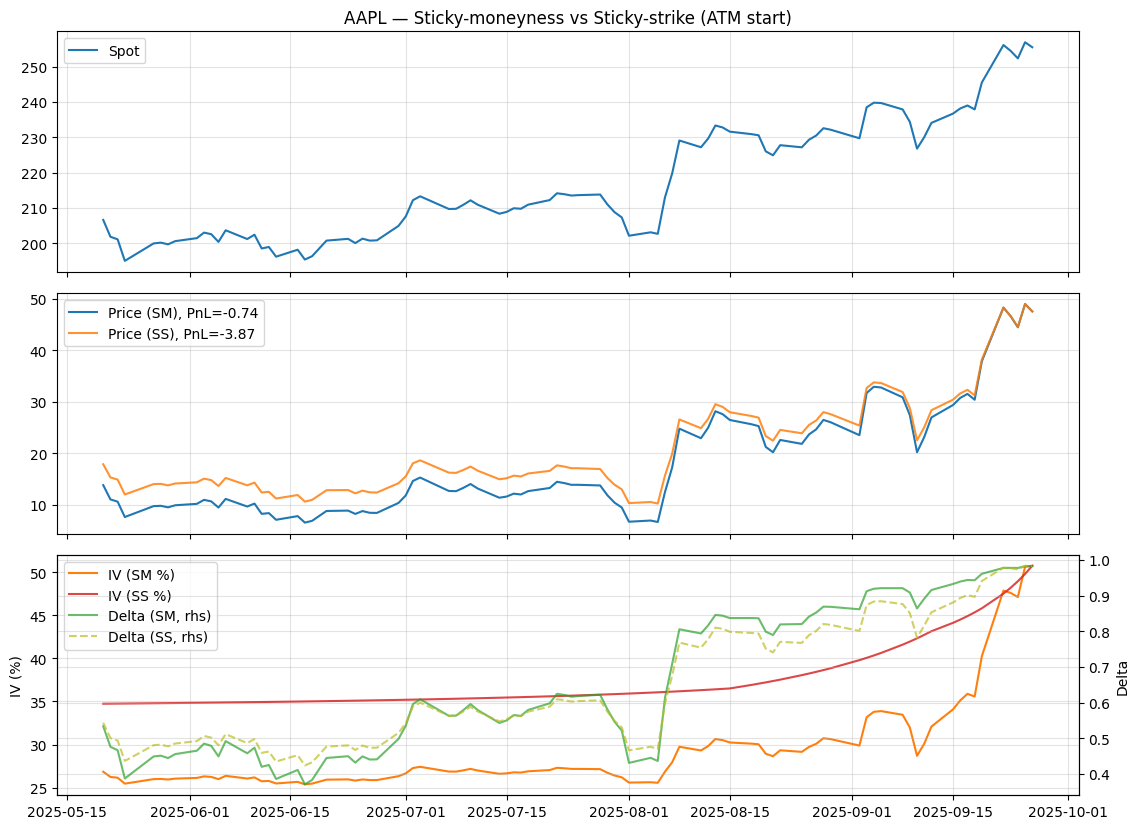

Summary (SM): {'StartPx': 13.835812864819076, 'EndPx': 47.532159022152314, 'AvgIV%': 29.338714323593067, 'Δmin': 0.3703380719328355, 'Δmax': 0.9827343938538702}
Summary (SS): {'StartPx': 17.885521676451262, 'EndPx': 47.532159022152314, 'AvgIV%': 37.53222158340138, 'Δmin': 0.4232946107090693, 'Δmax': 0.9837292372065845}


In [9]:
# === Sticky-Moneyness vs Sticky-Strike — fully self-contained ===
import math, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from data.data_loader import fetch_stock_data, get_latest_price, fetch_current_chain
from src.black_scholes import black_scholes_price
from src.svi_surface import fit_svi_surface

plt.rcParams.update({"figure.figsize": (11.5, 8.4), "axes.grid": True, "grid.alpha": 0.35})

# ---------- helpers ----------
def bs_delta_call(S, K, T, r, q, sigma):
    if T <= 0 or sigma <= 0:
        return 1.0 if S > K else 0.0
    F = S * math.exp((r - q) * T)
    volT = sigma * math.sqrt(T)
    d1 = (math.log(F / K) + 0.5 * volT * volT) / volT
    Phi = 0.5 * (1.0 + math.erf(d1 / math.sqrt(2.0)))
    return math.exp(-q * T) * Phi

def invert_iv_call_mid(S, K, T, r, q, mid, tol=1e-8, iters=80):
    F = S * math.exp((r - q) * T)
    lower = max(0.0, math.exp(-r * T) * (F - K))
    upper = S * math.exp(-q * T)
    p = float(np.clip(mid, lower, upper))
    lo, hi = 1e-6, 5.0
    for _ in range(iters):
        m = 0.5 * (lo + hi)
        pm = black_scholes_price(S, K, T, r, m, option_type="call")
        hi, lo = (m, lo) if pm > p else (hi, m)
        if hi - lo < tol: break
    return 0.5 * (lo + hi)

def build_surface_snapshot_from_dataloader(ticker, S_ref, r, q, snapshot_date, max_expiries=8):
    raw = fetch_current_chain(ticker)
    if raw is None or raw.empty: raise RuntimeError("chain empty")
    raw = raw.dropna().copy(); raw["type"] = raw["type"].str.lower()
    calls = raw[(raw["type"]=="call") & (raw["mid"]>1e-4) & (raw["strike"]>1e-6)].copy()
    exps = np.sort(pd.to_datetime(calls["expiration"].unique()))
    pick_idx = np.round(np.linspace(0, len(exps)-1, min(max_expiries, len(exps)))).astype(int)
    picked = [exps[i] for i in pick_idx]
    t0 = np.datetime64(pd.to_datetime(snapshot_date))
    chains = {}
    for exp in picked:
        sl = calls[calls["expiration"]==exp].copy()
        T = max(1e-9, (np.datetime64(exp) - t0) / np.timedelta64(1, "D")) / 365.0
        if T <= 0: continue
        F_T = S_ref * math.exp((r - q) * T)
        k = np.log(sl["strike"].to_numpy(float) / F_T)
        band = 0.35 if T < 0.03 else (0.5 if T < 0.15 else 0.7)
        sl = sl.iloc[np.where(np.abs(k) <= band)[0]]
        if sl.empty: continue
        K = sl["strike"].to_numpy(float); M = sl["mid"].to_numpy(float)
        ivs = np.array([invert_iv_call_mid(S_ref, float(k_), T, r, q, float(p_)) for k_, p_ in zip(K, M)])
        if ivs.size >= 12:
            lo, hi = np.quantile(ivs, [0.05, 0.95])
            keep = (ivs>1e-4) & (ivs<3.0) & (ivs>=lo) & (ivs<=hi)
            K, ivs = K[keep], ivs[keep]
        if K.size >= 10: chains[T] = {"K": K, "iv": ivs}
    if not chains: raise RuntimeError("no clean expiries after filtering")
    return fit_svi_surface(chains, S0=S_ref, r=r, q=q, mode="iv"), chains

def iv_sm(surf, S, K, T, r, q, S_snap=None):
    Tq = float(np.clip(T, np.min(surf.tenors), np.max(surf.tenors)))
    F  = S * np.exp((r - q) * Tq)
    k  = np.log(K / F)
    iv = float(surf.iv(np.array([k]), Tq))
    return max(iv, 1e-4)

def iv_ss(surf, S, K, T, r, q, S_snap):
    Tq = float(np.clip(T, np.min(surf.tenors), np.max(surf.tenors)))
    F_snap_T = S_snap * np.exp((r - q) * Tq)
    k_star   = np.log(K / F_snap_T)
    iv = float(surf.iv(np.array([k_star]), Tq))
    return max(iv, 1e-4)

def backtest_with_ivfn(S, dates, K, expiry, r, q, surf, iv_fn, label, S_snap=None):
    S = np.asarray(S, float).reshape(-1)
    dates = pd.to_datetime(dates)
    n = S.shape[0]
    cash = 0.0; pos_stock = 0.0
    prices, deltas, vols, times = [], [], [], []
    # t0
    T = max(0.0, (expiry - dates[0]).days/365.0)
    sigma = iv_fn(surf, S[0], K, T, r, q, S_snap)
    price = black_scholes_price(S[0], K, T, r, sigma, option_type="call")
    delta = bs_delta_call(S[0], K, T, r, q, sigma)
    pos_stock = -delta; cash = -price + (-pos_stock)*S[0]
    prices.append(price); deltas.append(delta); vols.append(sigma); times.append(T)
    for t in range(1, n):
        dt = max(1/365, (dates[t]-dates[t-1]).days/365.0)
        cash *= math.exp(r*dt)
        T = max(0.0, (expiry - dates[t]).days/365.0)
        sigma = iv_fn(surf, S[t], K, T, r, q, S_snap)
        price_new = black_scholes_price(S[t], K, T, r, sigma, option_type="call")
        delta_new = bs_delta_call(S[t], K, T, r, q, sigma)
        d_pos = -delta_new - pos_stock
        cash -= d_pos * S[t]; pos_stock += d_pos
        prices.append(price_new); deltas.append(delta_new); vols.append(sigma); times.append(T)
    payoff = max(S[-1]-K, 0.0); cash += payoff + pos_stock*S[-1]
    track = pd.DataFrame({
        "S":S, "time":np.asarray(times,float), "sigma":np.asarray(vols,float),
        "price":np.asarray(prices,float), "delta":np.asarray(deltas,float), "model":label
    }, index=pd.DatetimeIndex(dates))
    return cash, track

# ---------- inputs ----------
TICKER = "AAPL"; START = "2025-05-01"; r, q = 0.02, 0.00
stock_df = fetch_stock_data(TICKER, start=START)
S_series = stock_df["Close"].dropna()
snapshot_date = pd.to_datetime(stock_df.index[-1]); S_snap = get_latest_price(stock_df)

# surface snapshot (today’s chain vs snapshot_date)
surf, _ = build_surface_snapshot_from_dataloader(TICKER, S_ref=S_snap, r=r, q=q, snapshot_date=snapshot_date)

# pick nearest future expiry (≥ 7d after snapshot)
exps_all = np.sort(pd.to_datetime(fetch_current_chain(TICKER)["expiration"].unique()))
expiry = exps_all[exps_all > snapshot_date + pd.Timedelta(days=7)][0]

# backtest window: last 90 bdays up to snapshot
N_BACK = 90
S_series_win = S_series[S_series.index <= snapshot_date].iloc[-N_BACK:]
S0 = S_series_win.iloc[0].item()
T0 = (expiry - S_series_win.index[0]).days/365.0
K  = float(S0 * math.exp((r - q) * T0))  # true ATM at t0

# ---------- run both models ----------
pnl_sm, tr_sm = backtest_with_ivfn(S_series_win.values, S_series_win.index, K, expiry, r, q, surf, iv_sm, "SM")
pnl_ss, tr_ss = backtest_with_ivfn(S_series_win.values, S_series_win.index, K, expiry, r, q, surf, iv_ss, "SS", S_snap=S_snap)
print(f"PnL (Sticky-moneyness): {pnl_sm:.2f}")
print(f"PnL (Sticky-strike)  : {pnl_ss:.2f}")

# ---------- plot ----------
fig, ax = plt.subplots(3, 1, sharex=True)

ax[0].plot(S_series_win.index, S_series_win.values, label="Spot")
ax[0].set_title(f"{TICKER} — Sticky-moneyness vs Sticky-strike (ATM start)")
ax[0].legend(loc="upper left")

ax[1].plot(tr_sm.index, tr_sm["price"], label=f"Price (SM), PnL={pnl_sm:.2f}")
ax[1].plot(tr_ss.index, tr_ss["price"], label=f"Price (SS), PnL={pnl_ss:.2f}", alpha=0.85)
ax[1].legend(loc="upper left")

ax2 = ax[2].twinx()
ax[2].plot(tr_sm.index, tr_sm["sigma"]*100, label="IV (SM %)", color="tab:orange")
ax[2].plot(tr_ss.index, tr_ss["sigma"]*100, label="IV (SS %)", color="tab:red", alpha=0.85)
ax2.plot(tr_sm.index, tr_sm["delta"], color="tab:green", alpha=0.7, label="Delta (SM, rhs)")
ax2.plot(tr_ss.index, tr_ss["delta"], color="tab:olive", alpha=0.7, linestyle="--", label="Delta (SS, rhs)")
h1,l1 = ax[2].get_legend_handles_labels(); h2,l2 = ax2.get_legend_handles_labels()
ax[2].legend(h1+h2, l1+l2, loc="upper left")
ax[2].set_ylabel("IV (%)"); ax2.set_ylabel("Delta")

plt.tight_layout(); plt.show()

# summaries
def summarize(tr): 
    return {"StartPx":float(tr["price"].iloc[0]), "EndPx":float(tr["price"].iloc[-1]),
            "AvgIV%":float(tr["sigma"].mean()*100), "Δmin":float(tr["delta"].min()), "Δmax":float(tr["delta"].max())}
print("Summary (SM):", summarize(tr_sm))
print("Summary (SS):", summarize(tr_ss))
